## Game Theoretic Dynamic Weighting Based Feature Selection
### Adapted from the paper `Antimicrobial Resistance Prediction for Gram-Negative Bacteria via Game Theory-Based Feature Evaluation`, by Abu Sayed Chowdhury, Douglas R. Call, and Shira L. Broschat.

DOI: *10.1038/s41598-019-50686-z*
Their `R` code is [here](https://github.com/abu034004/GTDWFE/blob/master/code/GT_Feature_Selection.R)

The original paper was for only binary classification problems, when the classes were indicated by a -1 or 1. I have tried to adapt the algorithm to be more general.

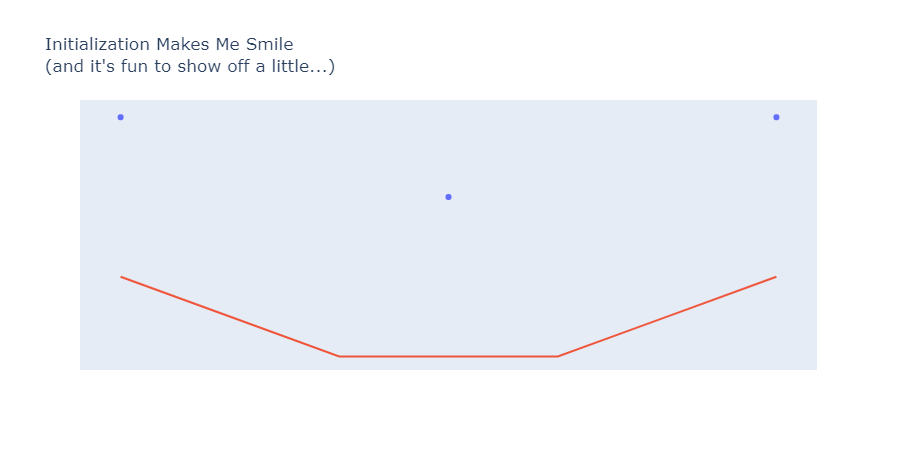

In [1]:
import math
import numpy as np
import pandas as pd
import datetime as dt
from collections import Counter
from IPython.display import display, Markdown, Latex, HTML, IFrame
import ipdb
from scipy.interpolate import interp1d
from scipy import arange, array, exp
from itertools import product, combinations, chain

import chart_studio.plotly as ply
import chart_studio.tools as plytool
import plotly.figure_factory as ff
import plotly.graph_objs as go
import plotly.offline as plyoff
import plotly.subplots as plysub

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer

# plotly initialization
# if using jupyter lab, must have the plotly extension installed: https://github.com/jupyterlab/jupyter-renderers/tree/master/packages/plotly-extension
# jupyter labextension install @jupyterlab/plotly-extension
plyoff.init_notebook_mode(connected=True)
x1 = [1,4,7]; y1 = [7,5,7]
x2 = [1,2,3,4,5,6,7]; y2 = [3,2,1,1,1,2,3]
plyoff.iplot(go.Figure(data=[go.Scatter({"x":x1, "y":y1, 'mode':'markers'}),
                             go.Scatter({"x":x2, "y":y2, 'mode':'lines'})],
                                        layout=go.Layout(autosize=False,width=500,title="Initialization Makes Me Smile<br>(and it's fun to show off a little...)",
                                                         showlegend=False, xaxis={'showgrid':False, 'showticklabels':False},
                                                         yaxis={'showgrid':False, 'showticklabels':False})))

# plotly authentication - not needed for offline mode
#plytool.set_credentials_file(username='ahowe42', api_key='')

In [2]:
def MutualInformation(UV):
    ''' Compute mutual information between two random variables, based on their empirical
    join probability distribution. '''
    n = UV.shape[0]
    # unique values & frequencies of each discretized feature
    freqU = Counter(UV[:,0])
    freqV = Counter(UV[:,1])
    # all possible combinations of each
    allUVs = list(product(freqU.keys(),freqV.keys()))
    
    # now iterate over all possible combos & compute the frequency
    probInfUV = np.zeros(shape=(len(allUVs),6)) # u, v, prob(u), prob(v), prob(u,v), I(u,v)
    for i,uv in enumerate(allUVs):
        # u & v
        probInfUV[i,0] = uv[0]
        probInfUV[i,1] = uv[1]
        # prob(u) & prob(v)
        probInfUV[i,2] = freqU[uv[0]]/n
        probInfUV[i,3] = freqV[uv[1]]/n
        # prob(u,v)
        probInfUV[i,4] = np.sum(np.all(UV == uv, axis=1))/n
        # I(u,v)
        if probInfUV[i,4] != 0:
            probInfUV[i,5] = probInfUV[i,4]*math.log(probInfUV[i,4]/(probInfUV[i,2]*probInfUV[i,3]))
    
    return np.sum(probInfUV[:,-1]), probInfUV

In [3]:
def ConditionalMutualInformation(UVZ):
    ''' Compute mutual information between two random variables, conditional upon a third
    random variable, based on their empirical joint probability distribution. '''
    n = UVZ.shape[0]
    # unique values & frequencies of each discretized feature
    freqU = Counter(UVZ[:,0])
    freqV = Counter(UVZ[:,1])
    freqZ = Counter(UVZ[:,2])
    # all possible combinations of UV
    allUVs = list(product(freqU.keys(),freqV.keys()))
    # all possible combinations of UVZ
    allUVZs = list(product(freqU.keys(),freqV.keys(),freqZ.keys()))
    
    # iterate over all values for Z & compute the conditional values
    probInfUVcondZ = dict.fromkeys(freqZ.keys(), None)
    for z in freqZ.keys():
        probInfUVcondZ[z] = dict.fromkeys(allUVs,None)
        # get the data for this z
        UV = UVZ[UVZ[:,-1]==z,:-1]
        nZ = UV.shape[0]
        # compute conditional frequencies
        fU = Counter(UV[:,0])
        fV = Counter(UV[:,1])
        # iterate over the possible combinations of U & V & compute the frequency
        for i,uv in enumerate(allUVs):
            # for this z, for this (u,v), store prob(u|z), prob(v|z), prob(u,v|z)
            probInfUVcondZ[z][uv] = [0,0,0]
            # prob(u|z) & prob(v|z)
            probInfUVcondZ[z][uv][0] = fU[uv[0]]/nZ
            probInfUVcondZ[z][uv][1] = fV[uv[1]]/nZ
            # prob(u,v|z)
            probInfUVcondZ[z][uv][2] = np.sum(np.all(UV == uv, axis=1))/nZ
    
    # now iterate over all possible combos & compute the frequency
    probInfUVZ = np.zeros(shape=(len(allUVZs),8)) # u, v, z, prob(u|z), prob(v|z), prob(u,v|z), p(u,v,z), I(u,v|z)
    for i,uvz in enumerate(allUVZs):
        # u, v, z
        probInfUVZ[i,0] = uvz[0]
        probInfUVZ[i,1] = uvz[1]
        probInfUVZ[i,2] = uvz[2]
        # get these conditional results
        mutInf = probInfUVcondZ[probInfUVZ[i,2]][uvz[:-1]]
        # conditional prob(u|z) & prob(v|z)
        probInfUVZ[i,3] = mutInf[0]
        probInfUVZ[i,4] = mutInf[1]
        # prob(u,v|z)
        probInfUVZ[i,5] = mutInf[2]
        # prob(u,v,z)
        probInfUVZ[i,6] = np.sum(np.all(UVZ == uvz, axis=1))/n
        # I(u,v|z)
        if probInfUVZ[i,5] != 0:
            probInfUVZ[i,7] = probInfUVZ[i,6]*math.log(probInfUVZ[i,5]/(probInfUVZ[i,3]*probInfUVZ[i,4]))
    
    return np.sum(probInfUVZ[:,-1]), probInfUVZ, probInfUVcondZ

In [4]:
def GTDWFE(K, features, target, featBinarizer, targBinarizer, coalSize=3):
    ''' Implements the Game-Theoretic dynamic weighted feature selection algorithm. I adopted
    it from the reference listed above. There were some ambiguities between the R code
    the authors provided and the mathematical formulas in the paper. Where I have been unsure,
    I have followed what I understood from the paper.
    K: integer features to keep
    features: features from which to feature select
    target: the target response variable
    featBinarizer: sklearn binarizer for the input features; None if not needed
    targBinarizer: sklearn binarizer for the response variable; None if not needed
    coalSize: integer coalition size for evaluating joint information
    Returns:
    featKeep: list of features to keep
    wHistory: history of feature weights
    mutInf: dictionary holding, for all pairs of columns, the mutual and conditional mutual information
    '''
    p = features.shape[1]
    columns = list(range(p))
    
    # discretize the features & target
    discFeat = features
    discTarg = target
    if featBinarizer is not None:
        discFeat = featBinarizer.fit_transform(features).astype(int)
    if targBinarizer is not None:
        discTarg = targBinarizer.fit_transform(target).astype(int)
   
    # compute norms & correlations & similarities & informations
    norms = np.zeros(shape=(p,))
    rhoV = np.zeros(shape=(p,))
    rhoD = np.zeros(shape=(p,))
    mutInf = dict.fromkeys(product(columns,columns), None)
    for i in columns:
        # ord=None is the 2-norm for vectors
        norms[i] = np.linalg.norm(features[:,i], ord=None)
        # pearson correlation between each feature & the target
        rhoV[i] = np.abs(np.corrcoef(features[:,i], np.squeeze(target)))[0,1]
        # tanimoto coefficient between all pairs of features
        for j in columns:
            if i == j:
                # no need to compute self-correlation
                continue
            dt = np.dot(features[:,i], features[:,j])
            rhoD[i] += dt / (norms[i] + norms[j] - dt)
            # while we're at it, compute all pairs of mutual information; I(i,target), I(i,target | j)
            MI = MutualInformation(np.c_[discFeat[:,i],discTarg])[0] # note the absence of j: mutInf[(i,j)][0] will all be the same for all j
            CMI = ConditionalMutualInformation(np.c_[discFeat[:,i],discTarg,discFeat[:,j]])[0]
            mutInf[(i,j)] = (MI, CMI, CMI > MI)
        # finish the similarity average
        rhoD[i] /= (p-1)
    
    # compute the "total correlation/similarity"
    rSum = rhoV + rhoD
    
    # setup to keep some diagnostic data
    wHistory = [norms,rhoV,rhoD,rSum] # history of the weights calculations

    # iterate over features we want to keep
    w = np.ones(shape=(p,))       # feature weights
    featKeep = []                 # features to keep
    columnsLeft = columns.copy()
    for t in range(K):
        # compute the keep-this-feature values
        l = [r*w for r,w in zip(rSum,w)]
        wHistory.append(w.copy()); wHistory.append(l)
        # select the maximum to identify the best feature to add (and remove from the list for consideration)
        indx = np.nanargmax(l)
        w[indx] = np.nan # set this weight to nan to ensure it doesn't get chosen again
        featKeep.append(indx)
        columnsLeft.remove(columns[indx])
        # talk a bit
        print('Iteration %d: kept %r'%(t,featKeep))
        # if we still need to add features, compute the banzhoff power indices to adjust the weights
        if t < K-1:
            for r in columnsLeft:
                banzhoff = 0
                # need to build all coalitions up to size coalSize that can be formed with feature r
                notr = columns.copy(); notr.remove(r)
                coalCount = 0
                for c in range(coalSize):
                    if len(notr) >= c:
                        # iterate over all formable coalitions of this size and compute information gains
                        sumTau = 0
                        sumCondInf = 0
                        coalitions = list(combinations(notr, r=c+1))
                        coalCount += len(coalitions)
                        for coal in coalitions:
                            if len(coal) == 1:
                                # simple lookup of information calculations
                                data = mutInf[(coal[0],r)]
                                sumTau += data[-1]                 # this is CMI > MI
                                sumCondInf += data[1]
                            else:
                                # must iterate through pairs in the coalition to get the information
                                for subCoal in product(coal, [r]):
                                    # now lookup the information
                                    sumTau += mutInf[subCoal][-1]   # this is CMI > MI
                                    sumCondInf += mutInf[subCoal][1]
                        # update banzhoff calculation
                        banzhoff += (sumCondInf > 0) & (sumTau >= math.ceil(len(coalitions)/2))
                # now finally update the feature weight with the banzhoff power calculation
                w[r] *= (1+banzhoff/coalCount)

    return featKeep, wHistory, mutInf

In [5]:
''' demonstrating selective discretization to not discretize already discrete columns'''
# generate the data, all features independent
np.random.seed(42)
n = 40
c = np.random.rand(n,3) # these should be discretized
d = np.random.randint(low=1, high=11, size=(n,2)) # these should not be discretized
data = np.c_[c,d]
print(pd.DataFrame(data).head())

# selective discretization
colsToDisc = [0,1,2]
k = [5,5,5]
kdisc = KBinsDiscretizer(n_bins = k, encode='ordinal', strategy='quantile') # quantile or uniform?
colTran = ColumnTransformer([('bind', kdisc, colsToDisc)], remainder='passthrough', n_jobs=-1) # just call me John! ;-)
discdata = colTran.fit_transform(data).astype(int)
print(pd.DataFrame(discdata).head())

          0         1         2     3    4
0  0.374540  0.950714  0.731994  10.0  7.0
1  0.598658  0.156019  0.155995   9.0  7.0
2  0.058084  0.866176  0.601115   1.0  1.0
3  0.708073  0.020584  0.969910   9.0  9.0
4  0.832443  0.212339  0.181825   4.0  9.0
   0  1  2   3  4
0  2  4  3  10  7
1  3  0  0   9  7
2  0  3  2   1  1
3  4  0  4   9  9
4  4  1  1   4  9


In [6]:
# generate a response variable
resp = data[:,0]*300 + data[:,2]*600 + data[:,4]*900
med = np.quantile(resp, q=0.5)
resp = resp > med
print(pd.DataFrame(resp).head())

       0
0   True
1   True
2  False
3   True
4   True


In [7]:
# perform the GTWDFE
keep = 3
featKeep, wHistory, mutInf = GTDWFE(K=keep, features=data, target=resp, featBinarizer=colTran, targBinarizer=None)
print(featKeep)

Iteration 0: kept [4]
Iteration 1: kept [4, 0]
Iteration 2: kept [4, 0, 3]
[4, 0, 3]
